# Overview

This is the __expert level__ version of [question 3](../novice/Q3.ipynb) from the novice level and [question 3](../intermediate/Q3.ipynb) from the intermediate level. Previously we focused on the frequency of the different types of lesion diagnosis and finding if there is a statistical difference between lesion types (regarding malignancy). This notebook focuses on clustering those same lesion diagnoses by looking at the images and using K-means. We want to see if the size of the clusters are similar to the frequencies found in the previous question. We do this to answer the following question: Does the clustering of lesion diagnosis align with the frequency chart from the beginner section? 

# Table of Content

1. [Setup](#setup_cell)
2. [Data Loading](#loading)
3. [Analysis](#analyze)
4. [Visualization](#viz_cell)
5. [Discussion](#discussion)

# Import <a id="setup_cell"></a>

In [1]:
import PIL
import cv2
import os
from os import listdir
from os.path import isfile, join
import json
import numpy as np
import seaborn as sns # pip install -U seaborn
from matplotlib import pyplot as plt
import pandas as pd
import glob
from IPython.display import display
from sklearn.cluster import KMeans
from tqdm import tqdm

# Data loading <a id="loading"></a>

In [2]:
img_filepaths = glob.glob('../../sample_imgs/*.jp*')
seg_filepaths = glob.glob('../../sample_segs/*.png')
dsc_filepaths = glob.glob('../../sample_dscs/*')

img_filepaths = sorted(img_filepaths)
seg_filepaths = sorted(seg_filepaths)
dsc_filepaths = sorted(dsc_filepaths)

There are more image and description files than segmentation so we have to make sure we only use the files that have images, segmentations and descriptions.

In [3]:
im_file_numbers = [str(i.split("_")[-1].split(".")[0]) for i in img_filepaths]
seg_file_numbers = [str(seg_filepaths[i].split("_")[2]) for i in range(len(seg_filepaths))]
des_file_numbers =  [str(dsc_filepaths[i].split("_")[2]) for i in range(len(dsc_filepaths))]
                     
all_files = [im_file_numbers, seg_file_numbers, des_file_numbers]

total_file_count = np.inf
total_files = []
for directory in all_files:
    if len(directory) < total_file_count:
        total_file_count = len(directory)
        total_files = directory

Here we have to make sure all of the files are in the same order so we're using the same segmentations for the images 

In [4]:
def consistency_fix(total_files):
    s = "_"
    images = []
    segs   = []
    dscs   = []
    
    im = img_filepaths[0].split("_")
    j = seg_filepaths[0].split("_")
    k = dsc_filepaths[0].split("_")
    
    for i in total_files:

        im_file  =  s.join(im[:2]) + "_" + i + "." + im[-1].split(".")[-1]
        seg_file =  s.join(j[:2]) + "_" + i + "_" + j[-1]
        des_file =  s.join(k[:2]) + "_" + i
        
        if isfile(im_file) & isfile(seg_file) & isfile(des_file):
            
            images.append(im_file)
            segs.append(seg_file)
            dscs.append(des_file)

        else:
            continue
            
    return images, segs, dscs

fixed_img, fixed_seg, fixed_dsc = consistency_fix(total_files)

One final check to make sure each image corresponds to it's segmentation

In [5]:
for i in range(len(fixed_img)):
    
    image_number = int(fixed_img[0].split("_")[-1].split(".")[0])
    segmentation_number = int(fixed_seg[0].split("_")[2])
    description_number =  int(fixed_dsc[0].split("_")[2])
    if image_number != segmentation_number or image_number != description_number:
        print("Error in file order")
        break

img_filepaths = fixed_img
seg_filepaths = fixed_seg
dsc_filepaths = fixed_dsc

# Analysis <a id="analyze"></a>

Here we have to grab all the images, their descriptions and segmentations.

In [6]:
all_images = []
classes = []
for i in tqdm(range(len(img_filepaths))): # replace with length of sample_imgs
    
    # Grab orignal image and segmented version 
    color =  PIL.Image.open(img_filepaths[i])
    segged = PIL.Image.open(seg_filepaths[i])
    
    json_file = open(dsc_filepaths[i]) 
    description = json.load(json_file)
    try:
        diag_class = description["meta"]["clinical"]['diagnosis']
        if diag_class != None:  
            classes.append(diag_class)
        else:
            classes.append("None")
    except KeyError:
        continue 
    # Try using different attributes for your classes
    #classes.append(description["meta"]["clinical"]['anatom_site_general'])
    #classes.append(description["meta"]["clinical"]['benign_malignant'])

    # Get blank background
    np_im = np.zeros((300,400))
    backtorgb = cv2.cvtColor(np.float32(np_im),cv2.COLOR_GRAY2RGB)

    blank_array = backtorgb * 255
    blank_array = blank_array.astype(np.uint8)
    sam = PIL.Image.fromarray(blank_array)

    # Copy original picture on blank background
    back_im = sam.copy()
    back_im.paste(color, (0, 0), segged)
    im_matrix = np.array(back_im)
    im_matrix = im_matrix.flatten()
    all_images.append(im_matrix)

100%|████████████████████████████████████████████████████████████████████████████| 10635/10635 [27:09<00:00,  6.53it/s]


K means needs numpy arrays

In [7]:
all_images = np.array(all_images)
all_images = all_images.astype('float64')
total_classes = len(set(classes))

Performs K-means algorithm <br>
K-means boils down to 5 steps: <br>
1. Randomly select centroids (centers of each cluster).
2. Calculate the distance of all data points to the centroids.
3. Assign data points to the closest cluster.
4. Find the new centroids of each cluster by taking the mean of all data points in the cluster.
5. Repeat steps 2,3 and 4 until all points converge or you reach your max iterations.

In [14]:
# Sklearn version (no GPU)
kmeans = KMeans(init='k-means++', n_clusters=total_classes, max_iter=500)
try:
    kmeans.fit(all_images)
except MemoryError:
    
    # Not enough memory must use toy data size
    all_images = all_images[:100]
    kmeans.fit(all_images)

We get the cluster predictions and all the different classes for the images

In [15]:
pred_classes = kmeans.predict(all_images)
classes = np.array(classes)

We must turn them into np arrays for easier processing

In [16]:
all_diagnosis = classes
all_clusters = pred_classes
all_diagnosis = np.array(all_diagnosis)
all_clusters = np.array(all_clusters)

### Here we do a couple of things: <br>
1. We look at the number of clusters we have
2. Then find classes that have been assigned to that cluster
3. We then count the number of times that class has appeared

In [17]:
cluster_data = dict()
for cluster in range(total_classes):

    mini_dic = dict()
    for i in np.unique(classes):
        index = np.where(pred_classes == cluster)
        #print(index)
        mini_dic[i] = list(classes[index]).count(i)

    cluster_data[cluster] = mini_dic

# Visualization <a id="viz_cell"><a/>
### It is hard to visualize clustering especially when working with high dimensional data like images. So you might have to get creative.


Here we used color to represent the clusters, count to represent the size of the clusters, and the x-axis for the classes. Usually we are not concerned with the exact class labels but in this case we want to know the number of different diagnoses in a cluster.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

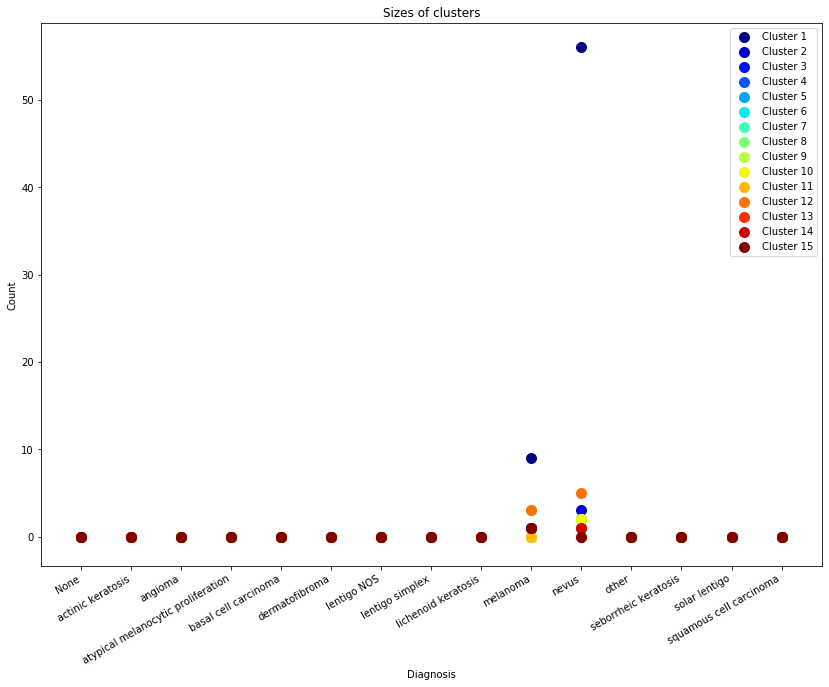

In [19]:
colors = plt.cm.jet(np.linspace(0,1,total_classes))
fig, ax = plt.subplots(figsize=(14,10))

for cluster in np.unique(all_clusters):

    ax.scatter(list(cluster_data[cluster].keys()), list(cluster_data[cluster].values()), c = colors[cluster], label = "Cluster " + str(cluster + 1), s = 100) 
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')    
plt.ylabel("Count")
plt.xlabel("Diagnosis")
plt.legend()
plt.title("Sizes of clusters")
plt.savefig("../expert_Q3_cluster.png")
plt.show()

### Now that we have clustered the images, we need to get the number of the correctly clustered images. <br>
This is a function that finds the dominate diagnosis in a cluster and the count. 

In [20]:
def get_diagnosis(cluster, cluster_data, tried_diagnoses):
    candidates = list(cluster_data[cluster].keys())
    candidate_counts = list(cluster_data[cluster].values())
    
    if len(tried_diagnoses) != 0:
        for diagnosis in tried_diagnoses:
            if diagnosis in candidates:
                candidate_counts.pop(candidates.index(diagnosis))
                candidates.pop(candidates.index(diagnosis))
    count = max(candidate_counts)
    dominant_diagnosis = candidates[candidate_counts.index(count)]
    
    return dominant_diagnosis, count

Here we have our clusters and the amount of correctly clustered images

In [21]:
cluster_sizes = dict()
counted_clusters = 0
for cluster in range(total_classes):
    
    while len(cluster_sizes) == counted_clusters:
        
        found_clusters = list(cluster_sizes.keys())
        diagnosis, count = get_diagnosis(cluster, cluster_data, found_clusters)
        if diagnosis not in found_clusters:
            cluster_sizes[diagnosis] = count
        else:
            diagnosis, count = get_diagnosis(cluster, cluster_data, found_clusters)
            
        
   
    counted_clusters += 1    

Now that we know the sizes of the cluster we want to see how well they represent the distribution. Here we load the data from question one.

In [22]:
frequency = pd.read_csv('../diagnosis_distribution.csv')
cluster_sizes =  pd.DataFrame(list(zip(cluster_sizes.keys(), cluster_sizes.values())), columns= ["Diagnosis", "Count"] )

frequency = frequency.sort_values(by=["Diagnosis"])
cluster_sizes = cluster_sizes.sort_values(by=["Diagnosis"])

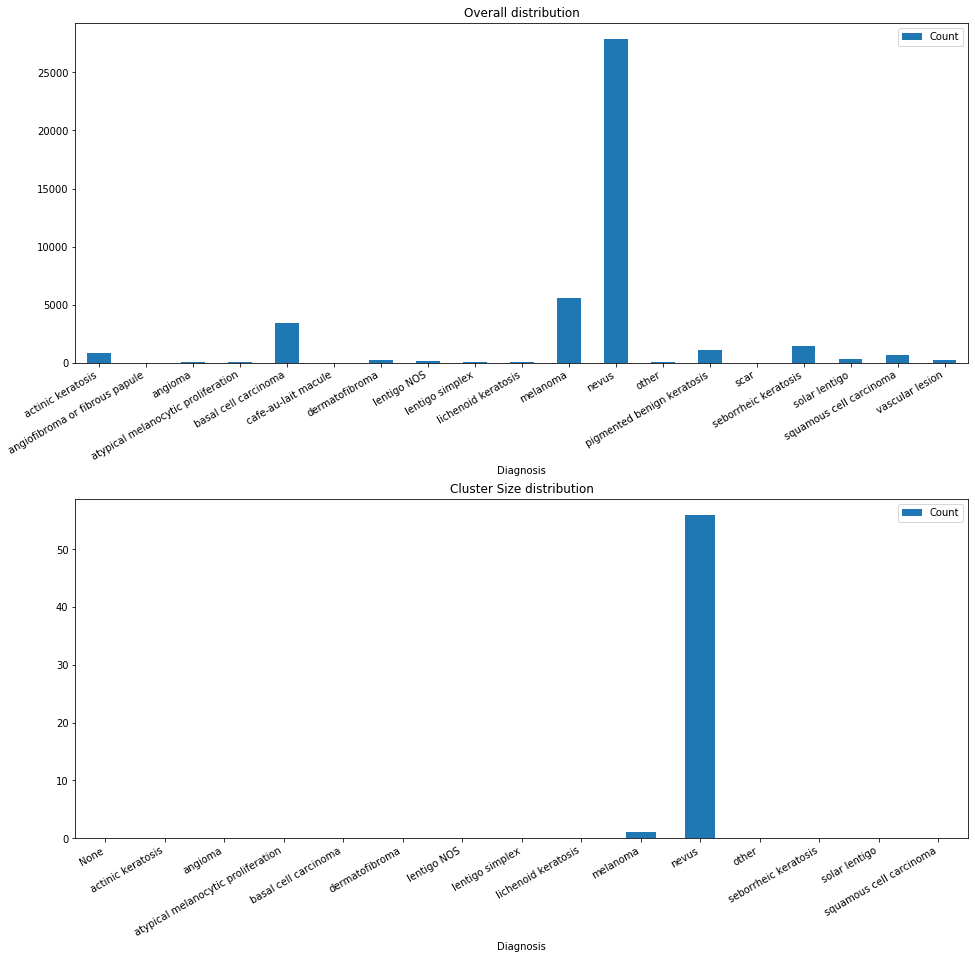

In [24]:
fig = plt.figure(figsize=(16,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title('Overall distribution')


frequency.plot.bar(x="Diagnosis", y="Count", ax=ax1)#plt.bar(list(frequency.keys()), list(frequency.values()), ax=ax1)
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title('Cluster Size distribution')

cluster_sizes.plot.bar(x="Diagnosis", y="Count", ax=ax2)
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.savefig("../expert_Q3_error.png")
plt.show()

# Discussion <a id=discussion></a>
Did KMeans put the diagnoses in the appropriate clusters? <br>
Does the amount of diagnoses look similar to the distribution in question 1 for novice? <br>
Was the difference large or small?